In [1]:
import sys
sys.path.append('..')

import optimus
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
import numpy as np
from optimus.source.transducers import transducer_field
from optimus.postprocess.plot import surface_plot

from utilities import FiniteDifference, RectangularPulse, TurkPulse

Importar archivo con incident pressure plot (IPP).

In [2]:
IPP_abs_load = np.loadtxt("MUSCLE_IPP_abs.txt")

IPP_abs = IPP_abs_load.reshape(
    IPP_abs_load.shape[0], IPP_abs_load.shape[1] // 201, 201) 

Escoger parámetros

In [5]:
np.max(IPP_abs) * 1e-6

16.000561602172866

In [3]:
frequency = 500e3
material_ext = optimus.material.load_material('muscle')

c_0 = material_ext.speed_of_sound
rho_0 = material_ext.density
C_t = material_ext.heat_capacity 
k_t = material_ext.thermal_conductivity
eta = material_ext.attenuation_pow_b 
alpha_0 = material_ext.attenuation_coeff_a 

Nx = 201
Ny = 101
Nz = 101

xmin, xmax, ymin, ymax, zmin, zmax = [-0.18, 0.18, -0.05, 0.05, -0.05, 0.05]

# Calcular Heat Deposition

In [4]:
#Reducir Dimensionalidad

IPP_small = [cut[51-25: 51+25+1, 101-50: 101+50+1] for cut in IPP_abs]
IPP_small = IPP_small[51-25: 51+25+1]
IPP_small = np.array(IPP_small)

intensity = (IPP_small)**2 / (c_0 * rho_0)
alpha = alpha_0 * frequency / 1000000
heat_deposition = intensity.copy()
heat_deposition = 2 * alpha * intensity

delta_x = (xmax - xmin) / Nx
delta_y = (ymax - ymin) / Ny
delta_z = (zmax - zmin) / Nz

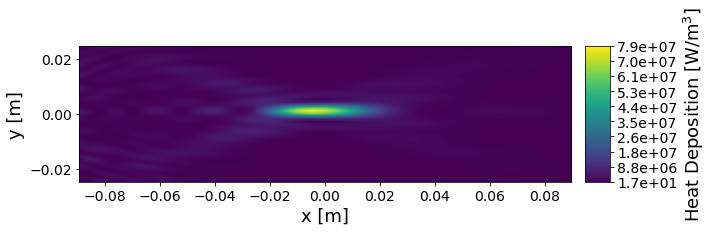

In [5]:
midpoint = heat_deposition[25]
fig = surface_plot(midpoint,
                   axes_lims=(delta_x * (-50), delta_x * (50), 
                              delta_y * (-25), delta_y * (25)),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='viridis',
                   colormap_lims=[np.min(midpoint),np.max(midpoint)],
                   colorbar_unit="Heat Deposition [W/m$^3$]",
                   )

# Diferencias Finitas

In [29]:
delta_t = 2e-5
Nt = int(1.5e4)
T_0 = np.zeros_like(heat_deposition) + 37

max_temp_ramp = []
max_temp_rect = []
max_temp_noat = []

prev_temp_ramp = T_0
prev_temp_rect = T_0
prev_temp_noat = T_0

time_domain = np.array(range(Nt)) * delta_t
rect_pulses = RectangularPulse(time_domain)
ramp_pulses = TurkPulse(time_domain)

In [30]:
%%time
for i in range(Nt):
    max_temp_ramp.append(np.max(prev_temp_ramp))
    max_temp_rect.append(np.max(prev_temp_rect))
    max_temp_noat.append(np.max(prev_temp_noat))
    
    prev_temp_ramp = FiniteDifference(temp_grid=prev_temp_ramp, 
                                      heat_deposition=heat_deposition, 
                                      attenuation=ramp_pulses[i],
                                      delta_x=delta_x,
                                      delta_y=delta_y,
                                      delta_z=delta_z,
                                      delta_t=delta_t)
    
    prev_temp_rect = FiniteDifference(temp_grid=prev_temp_rect, 
                                      heat_deposition=heat_deposition, 
                                      attenuation=rect_pulses[i],
                                      delta_x=delta_x,
                                      delta_y=delta_y,
                                      delta_z=delta_z,
                                      delta_t=delta_t)
    
    prev_temp_noat = FiniteDifference(temp_grid=prev_temp_noat, 
                                      heat_deposition=heat_deposition, 
                                      attenuation=1,
                                      delta_x=delta_x,
                                      delta_y=delta_y,
                                      delta_z=delta_z,
                                      delta_t=delta_t)

CPU times: user 13min 38s, sys: 27 ms, total: 13min 38s
Wall time: 28min 50s


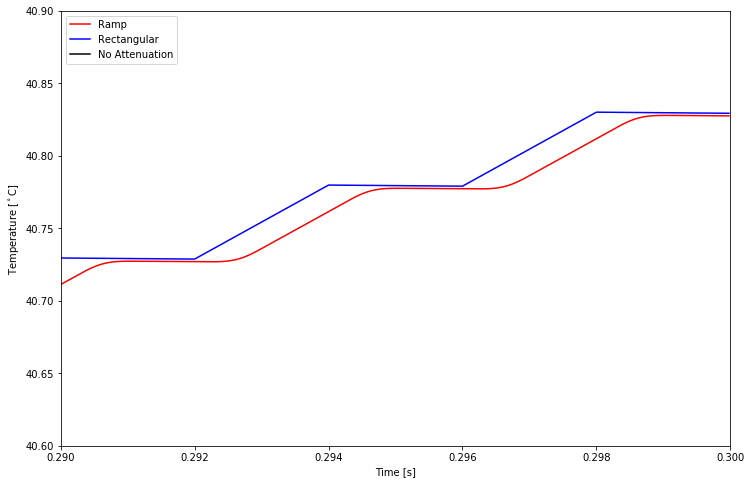

In [32]:
fig = plt.figure(figsize = (12,8))

plt.plot(time_domain, max_temp_ramp, c='red', label = 'Ramp')
plt.plot(time_domain, max_temp_rect, c='blue', label = 'Rectangular')
plt.plot(time_domain, max_temp_noat, c='black', label = 'No Attenuation')

plt.xlim(0.29, 0.3)
plt.ylim(40.6, 40.9)
plt.legend(loc = 'upper left')
plt.xlabel('Time [s]')
plt.ylabel('Temperature [$^\circ$C]')
plt.show()

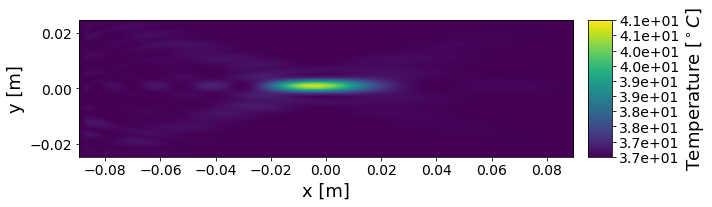

In [25]:
midpoint = prev_temp_ramp[24]
fig = surface_plot(midpoint,
                   axes_lims=(delta_x * (-50), delta_x * (50), 
                              delta_y * (-25), delta_y * (25)),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='viridis',
                   colormap_lims=[37, 41],
                   colorbar_unit="Temperature [$^\circ C$]",
                   )

# Convergencia Teórica

In [26]:
delta_t_2 = 2e-2
Nt_2 = int(4e4)
T_0 = np.zeros_like(heat_deposition) + 37

max_temp_noat_2 = []

prev_temp_noat_2 = T_0

time_domain_2 = np.array(range(Nt_2)) * delta_t_2

In [27]:
%%time
for i in range(Nt_2):
    max_temp_noat_2.append(np.max(prev_temp_noat_2))
    
    prev_temp_noat_2 = FiniteDifference(temp_grid=prev_temp_noat_2, 
                                      heat_deposition=heat_deposition, 
                                      attenuation=1,
                                      delta_x=delta_x,
                                      delta_y=delta_y,
                                      delta_z=delta_z,
                                      delta_t=delta_t_2)

CPU times: user 11min 56s, sys: 22.5 ms, total: 11min 56s
Wall time: 17min 3s


Text(0, 0.5, 'Temperature [$^\\circ$C]')

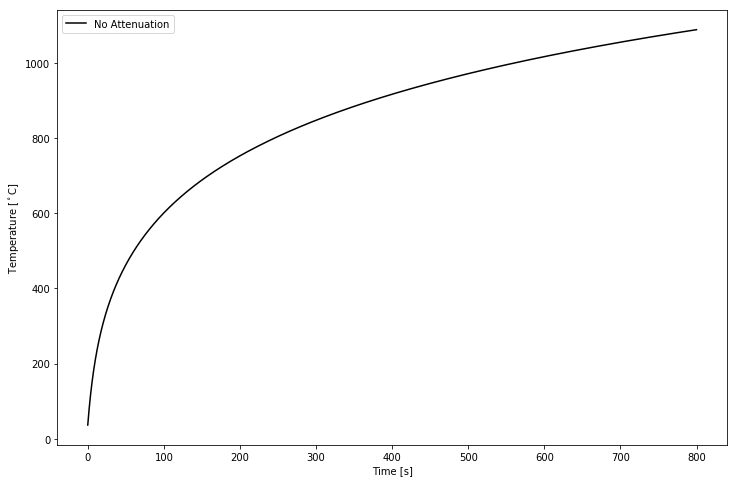

In [28]:
fig = plt.figure(figsize = (12,8))

plt.plot(time_domain_2, max_temp_noat_2, c='black', label = 'No Attenuation')

plt.legend(loc = 'upper left')
plt.xlabel('Time [s]')
plt.ylabel('Temperature [$^\circ$C]')

- Arreglar factor de 2 en intensidad (/$2p_0c_0$)
- Alrededor de 1[mPa]
- Probar apagar fuentes y ver cuanto demora en enfriarse
- Usar Np
- Probar bowl (notebook abierto) y no correr SOLVE.